In [34]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

In [35]:
all_letters = 'abcdefghijklmnopqrstuvwxyz_'
n_letters = len(all_letters)

In [36]:
#Returns an index number as location of any letter in all_letters | Example: letter2index('a') -> 0
def letter2index(letter):
    return all_letters.find(letter)

In [37]:
#Returns an index number as location of any letter in all_letters | Example: letter2index('a') -> 0
def name2index(name):
    name_idx = [letter2index(i) for i in name]
    return name_idx

In [38]:
#Returns an one-hot encoding tensor letter index is 1 and others are 0.(tensor size: 1,n_letters)
def letter2tensor(letter):
    idx = letter2index(letter)
    torch_vec = torch.zeros(n_letters)
    torch_vec[idx] = 1
    return torch_vec

In [39]:
#Returns a tensor which include one-hot-encoded letter tensors inside.(tensor size: batch_size,name_length,n_letters)
def idxvec2tensor(name):
    name_letter_tensor = torch.zeros(len(name),1,n_letters)
    for batch_idx,name_i in enumerate(name):
        for idx,letter in enumerate(name_i):
            name_letter_tensor[batch_idx][idx][letter] = 1
    return name_letter_tensor

In [40]:
def idxvec2tensor1(name):
    name_letter_tensor = torch.zeros(len(name),1,n_letters)
    for batch_idx,name_i in enumerate(name):
        for idx,letter in enumerate(name_i):
            name_letter_tensor[batch_idx][idx][letter] = 1
    return name_letter_tensor

In [41]:
english_names = pd.read_excel('english_names.xlsx')
english_names.iloc[:10]

,name
0,Aaden
1,Aaliyah
2,Aarav
3,Aaron
4,Ab
5,Abagail
6,Abb
7,Abbey
8,Abbie
9,Abbigail


In [42]:
english_names

,name
0,Aaden
1,Aaliyah
2,Aarav
3,Aaron
4,Ab
...,...
6777,Zollie
6778,Zona
6779,Zora
6780,Zula


In [43]:
len(english_names)

6782

In [44]:
flatten_name_list = list(english_names.values.reshape(-1)[:-1])
flatten_name_list = [i.lower() for i in flatten_name_list]

In [45]:
def create_dataset1(str1):
    lst1 = [i for i in str1] + ['_']
    lst2 = [name2index(i) for i in lst1]
    x = lst2[:-1]
    y = lst2[1:]
    return x,y

In [46]:
name2index('_')

[26]

In [47]:
main_dataset_X = []
main_dataset_y = []
for name in flatten_name_list:
    x,y = create_dataset1(name)
    for lst in x:
        main_dataset_X.append(lst)
    for lst in y:
        main_dataset_y.append(lst)

In [48]:
#Feature and target tensors are splited as train and test set as rate %10.
from sklearn.model_selection import train_test_split
X_train, X_test , y_train ,y_test = train_test_split(main_dataset_X,main_dataset_y,test_size=0.1,random_state=42)

In [49]:
#Train and test samples are splited as batch_size for preparing to training and testing.
def train_test_loader(X_train,y_train,X_test,y_test,batch_size):
    train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size,drop_last=True)

    valid_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size,drop_last=True)
    return train_loader,valid_loader

In [50]:
# check if GPU is available
gpu_device = torch.cuda.is_available()

In [51]:
class CharLSTM(nn.Module):
    
    def __init__(self, n_letters, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.embed = nn.Embedding(n_letters, n_hidden*2) #boyut sabit
        self.lstm = nn.LSTM(n_hidden*2, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True,bidirectional=True)

        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden*2, n_letters)
        self.fc.weight = self.embed.weight
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        #argmax_x = torch.argmax(x,dim=1).view(x.size()[0],1)
        argmax_x = torch.argmax(x,dim=2)
        embed = self.embed(argmax_x)
        r_output, hidden = self.lstm(embed, hidden)
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden*2) #layer a girebilmek için 2d olmak zorunda ! her batch için 2liler birleşiyor.
        out = self.fc(out) #her karakter icin bir karakter tahmini
        # return outputs and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        # Create two new tensors with sizes 2*n_layers x batch_size x n_hidden,
        weight = next(self.parameters()).data
        
        if (gpu_device):
            hidden = (weight.new(self.n_layers*2, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers*2, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers*2, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers*2, batch_size, self.n_hidden).zero_())
        
        return hidden
        

In [71]:
def train1(batch_size,net,epochs=10,lr=0.001, clip=5, print_every=10):
    net.train()
    train_losses = []
    val_losses = []
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    h = net.init_hidden(batch_size)
    if(gpu_device):
        net.cuda()
    
    counter = 0
    #n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        
        #for x, y in zip(main_dataset_X,main_dataset_y):
        for batch in train_loader:
            counter += 1
            x = batch[0]
            y = batch[1]
            # One-hot encode our data and make them Torch tensors
            x = idxvec2tensor(x)
            #inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            inputs, targets = x,y
            if(gpu_device):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size).long())
            loss.backward()
            # prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                net.eval()
                for batch in valid_loader:
                    # One-hot encode our data and make them Torch tensors
                    x = batch[0]
                    y = batch[1]
                    x = idxvec2tensor(x)
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    inputs, targets = x, y
                    if(gpu_device):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size).long())
                    train_losses.append(loss)
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
    return train_losses,val_losses

In [72]:
# define and print the net
n_hidden= 15
n_layers= 1

net = CharLSTM(n_letters, n_hidden, n_layers)
print(net)

CharLSTM(
  (embed): Embedding(27, 30)
  (lstm): LSTM(30, 15, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=30, out_features=27, bias=True)
)


c:\Users\dogucan.elci\Miniconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [73]:
batch_size = 64
n_epochs = 10

# train the model
train_losses,val_losses = train1(batch_size,net,epochs=n_epochs,lr=0.001, print_every=10)

Epoch: 1/10... Step: 10... Loss: 4.0360... Val Loss: 3.4715
Epoch: 1/10... Step: 20... Loss: 3.8635... Val Loss: 3.3952
Epoch: 1/10... Step: 30... Loss: 3.2816... Val Loss: 3.3307
Epoch: 1/10... Step: 40... Loss: 3.4232... Val Loss: 3.2752
Epoch: 1/10... Step: 50... Loss: 3.1999... Val Loss: 3.2289
Epoch: 1/10... Step: 60... Loss: 3.2998... Val Loss: 3.1891
Epoch: 1/10... Step: 70... Loss: 3.0316... Val Loss: 3.1543
Epoch: 1/10... Step: 80... Loss: 3.0845... Val Loss: 3.1232
Epoch: 1/10... Step: 90... Loss: 3.2470... Val Loss: 3.0954
Epoch: 1/10... Step: 100... Loss: 2.8847... Val Loss: 3.0701
Epoch: 1/10... Step: 110... Loss: 2.8478... Val Loss: 3.0472
Epoch: 1/10... Step: 120... Loss: 3.1274... Val Loss: 3.0261
Epoch: 1/10... Step: 130... Loss: 3.0008... Val Loss: 3.0069
Epoch: 1/10... Step: 140... Loss: 2.9241... Val Loss: 2.9892
Epoch: 1/10... Step: 150... Loss: 3.0020... Val Loss: 2.9730
Epoch: 1/10... Step: 160... Loss: 2.6872... Val Loss: 2.9580
Epoch: 1/10... Step: 170... Loss:

In [74]:
len(val_losses), len(train_losses)

(35030, 35030)

In [102]:
val_losses1 = [val_losses[i] for i in range(len(val_losses)) if i%10 == 0]
train_losses1  = [float(train_losses[i]) for i in range(len(train_losses)) if i%10 == 0]

In [103]:
list(train_losses1)

[4.035966873168945,
 4.035966873168945,
 4.035966873168945,
 4.035966873168945,
 4.035966873168945,
 4.035966873168945,
 4.035966873168945,
 3.8635060787200928,
 3.8635060787200928,
 3.8635060787200928,
 3.8635060787200928,
 3.8635060787200928,
 3.8635060787200928,
 3.2815744876861572,
 3.2815744876861572,
 3.2815744876861572,
 3.2815744876861572,
 3.2815744876861572,
 3.2815744876861572,
 3.4231982231140137,
 3.4231982231140137,
 3.4231982231140137,
 3.4231982231140137,
 3.4231982231140137,
 3.4231982231140137,
 3.199873685836792,
 3.199873685836792,
 3.199873685836792,
 3.199873685836792,
 3.199873685836792,
 3.199873685836792,
 3.2998385429382324,
 3.2998385429382324,
 3.2998385429382324,
 3.2998385429382324,
 3.2998385429382324,
 3.2998385429382324,
 3.2998385429382324,
 3.0316073894500732,
 3.0316073894500732,
 3.0316073894500732,
 3.0316073894500732,
 3.0316073894500732,
 3.0316073894500732,
 3.084507703781128,
 3.084507703781128,
 3.084507703781128,
 3.084507703781128,
 3.084507

In [76]:
import matplotlib.pyplot as plt

In [94]:
val_losses1

[3.518235683441162,
 3.430284261703491,
 3.41550874710083,
 3.386406660079956,
 3.624563217163086,
 3.404479503631592,
 3.215557813644409,
 3.283827781677246,
 3.50876784324646,
 3.24821138381958,
 3.3976049423217773,
 3.288869857788086,
 3.2058699131011963,
 3.083367109298706,
 3.2840583324432373,
 3.2362663745880127,
 3.167964458465576,
 3.188382387161255,
 3.1983695030212402,
 3.051311731338501,
 2.865999937057495,
 3.080544948577881,
 3.2111518383026123,
 3.1268067359924316,
 3.302002429962158,
 3.049600124359131,
 3.0081186294555664,
 3.1724319458007812,
 2.9634130001068115,
 2.8007328510284424,
 2.9103856086730957,
 3.133862257003784,
 2.793113946914673,
 2.8698630332946777,
 2.9090402126312256,
 3.0469305515289307,
 2.9706573486328125,
 2.8281400203704834,
 2.9320125579833984,
 3.092074394226074,
 2.847559690475464,
 3.02785325050354,
 2.973076820373535,
 2.910928726196289,
 2.840477466583252,
 2.969102144241333,
 2.9422812461853027,
 2.8197438716888428,
 2.897735834121704,
 2.9

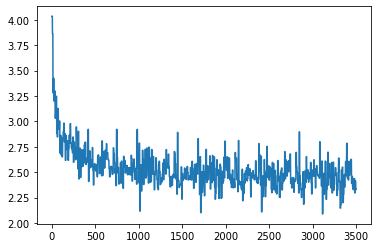

In [104]:
plt.plot(np.arange(len(train_losses1)),train_losses1)

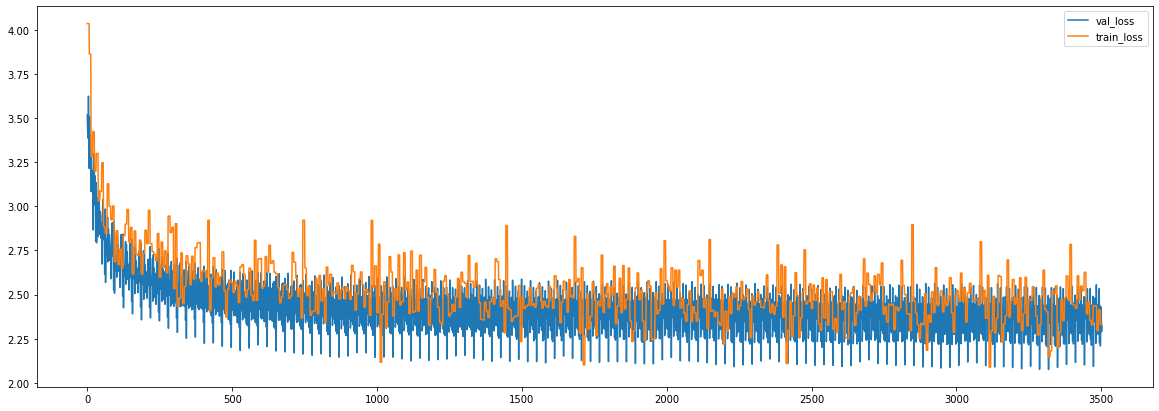

In [106]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(val_losses1)),val_losses1)
plt.plot(np.arange(len(train_losses1)),train_losses1)
plt.legend(['val_loss','train_loss'])

In [55]:
def predict1(pred_name):
    total_name = ''
    pred_name_ori = pred_name
    while len(total_name)<3:
        total_name = ''
        pred_name = pred_name_ori
        total_name += pred_name
        end_char = False
        while end_char==False:
            name_idx = name2index(pred_name)
            name_idx_tensor = torch.tensor(name_idx).view(1,len(name_idx))
            name_tensor = idxvec2tensor(name_idx_tensor)
            val_h = net.init_hidden(1)
            val_h = tuple([each.data for each in val_h])
            inputs = name_tensor
            if(gpu_device):
                inputs = inputs.cuda()
            output, val_h = net(inputs, val_h)
            pred_chars = ''
            output_last_idx = torch.argmax(output[-1],dim=0)
            if all_letters[output_last_idx] == '_':
                end_char = True
                break
            pred_chars += all_letters[output_last_idx]
            total_name += pred_chars
            pred_name = pred_chars
    return''.join(total_name)

In [56]:
predict1('j')

'jon'

In [57]:
predict1('m')

'mie'

In [113]:
predict1('a')

'anera'

In [59]:
predict1('l')

'lin'

In [156]:
predict1('b')

'brin'

In [61]:
predict1('w')

'wie'

In [123]:
predict1('s')

'stta'

In [153]:
predict1('d')

'daria'